In [42]:
import torch
import numpy as np
from torch import nn, optim
from tqdm import tqdm
from matplotlib import pyplot as plt

In [43]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
print(device)

mps


In [44]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, hidden_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, input_size)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [45]:
loss = nn.MSELoss()

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu" 
print(f"using {device} device")
 
autoenc = AutoEncoder(input_size=1024, hidden_size=2).to(device=device)
learning_rate = 4e-3
optm = torch.optim.Adam(autoenc.parameters(), lr=learning_rate)

using mps device


In [65]:
def train(data, model, opt):
    model.train()
    for X in tqdm(data):
        X = X.to(device)

        opt.zero_grad()
        pred = model(X)
        l = loss(pred, X)
        l.backward()
        opt.step()

def test(data, model, loss):
    full_loss = 0
    with torch.no_grad():
        for X in data:
            X = X.to(device)
            pred = model(X)
            l = loss(pred, X)
            full_loss += l.item()
        print(f"Test Loss: {round(np.mean(full_loss), 4)}")

In [79]:
data = np.load("Data/dataset.npy")
dataset_len = data.shape[0]
train_size = int(dataset_len * 1)

labels = np.zeros(120, dtype=int)
labels[:50] = 1
labels[50:100] = 2
labels[100:] = -1
labels_column = np.expand_dims(labels, axis=1)

dataset = np.concatenate((data, labels_column), axis=1)
print(dataset[:, -1])
np.random.shuffle(dataset)
print(dataset[:, -1])
train_data = torch.tensor(dataset[:train_size, :-1], dtype=torch.float32).to(device)
test_data = torch.tensor(dataset[train_size:, :-1], dtype=torch.float32).to(device)
print(train_data.shape, test_data.shape)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 1.  2.  2.  1.  2.  1.  1.  2.  1.  2.  1.  1.  1.  2.  2. -1.  1.  2.
 -1.  1.  1.  1. -1.  2.  1.  2.  2. -1.  1. -1. -1.  1.  1.  1.  2.  2.
  2.  1.  1.  2.  2.  1.  1.  1.  1.  1.  2.  2.  1.  2.  1.  2.  1.  1.
  2.  1.  2.  2.  1.  2.  1. -1.  2.  2. -1.  2.  1. -1. -1. -1.  2. -1.
  2. -1. -1.  2.  2.  2. -1.  1. -1.  1.  2.  2.  1.  1.  1.  2.  2.  1.
 -1.  1.  1.  2.  2.  2.  1.  2.  2.  1. -1.  2.  2. -1.  1.  2.  1.  1.
  1.  2.  1. -1.  2.  1.  2.  1.  1.  2.  2.  2.]
torch.Size([120, 1024]) 

In [80]:
EPOCHS = 25
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    train(train_data, autoenc, optm)
    test(test_data, autoenc, loss)

Epoch 0


100%|██████████| 120/120 [00:01<00:00, 76.50it/s]


Test Loss: 0.0
Epoch 1


100%|██████████| 120/120 [00:01<00:00, 80.74it/s]


Test Loss: 0.0
Epoch 2


100%|██████████| 120/120 [00:01<00:00, 80.73it/s]


Test Loss: 0.0
Epoch 3


100%|██████████| 120/120 [00:01<00:00, 83.24it/s]


Test Loss: 0.0
Epoch 4


100%|██████████| 120/120 [00:01<00:00, 82.45it/s]


Test Loss: 0.0
Epoch 5


100%|██████████| 120/120 [00:01<00:00, 84.75it/s]


Test Loss: 0.0
Epoch 6


100%|██████████| 120/120 [00:01<00:00, 85.39it/s]


Test Loss: 0.0
Epoch 7


100%|██████████| 120/120 [00:01<00:00, 79.42it/s]


Test Loss: 0.0
Epoch 8


100%|██████████| 120/120 [00:01<00:00, 82.26it/s]


Test Loss: 0.0
Epoch 9


100%|██████████| 120/120 [00:01<00:00, 81.94it/s]


Test Loss: 0.0
Epoch 10


100%|██████████| 120/120 [00:01<00:00, 81.13it/s]


Test Loss: 0.0
Epoch 11


100%|██████████| 120/120 [00:01<00:00, 82.51it/s]


Test Loss: 0.0
Epoch 12


100%|██████████| 120/120 [00:01<00:00, 82.81it/s]


Test Loss: 0.0
Epoch 13


100%|██████████| 120/120 [00:01<00:00, 81.62it/s]


Test Loss: 0.0
Epoch 14


100%|██████████| 120/120 [00:01<00:00, 85.80it/s]


Test Loss: 0.0
Epoch 15


100%|██████████| 120/120 [00:01<00:00, 85.05it/s]


Test Loss: 0.0
Epoch 16


100%|██████████| 120/120 [00:01<00:00, 85.56it/s]


Test Loss: 0.0
Epoch 17


100%|██████████| 120/120 [00:01<00:00, 85.19it/s]


Test Loss: 0.0
Epoch 18


100%|██████████| 120/120 [00:01<00:00, 86.05it/s]


Test Loss: 0.0
Epoch 19


100%|██████████| 120/120 [00:01<00:00, 86.46it/s]


Test Loss: 0.0
Epoch 20


100%|██████████| 120/120 [00:01<00:00, 85.59it/s]


Test Loss: 0.0
Epoch 21


100%|██████████| 120/120 [00:01<00:00, 82.04it/s]


Test Loss: 0.0
Epoch 22


100%|██████████| 120/120 [00:01<00:00, 80.90it/s]


Test Loss: 0.0
Epoch 23


100%|██████████| 120/120 [00:01<00:00, 85.28it/s]


Test Loss: 0.0
Epoch 24


100%|██████████| 120/120 [00:01<00:00, 84.71it/s]

Test Loss: 0.0


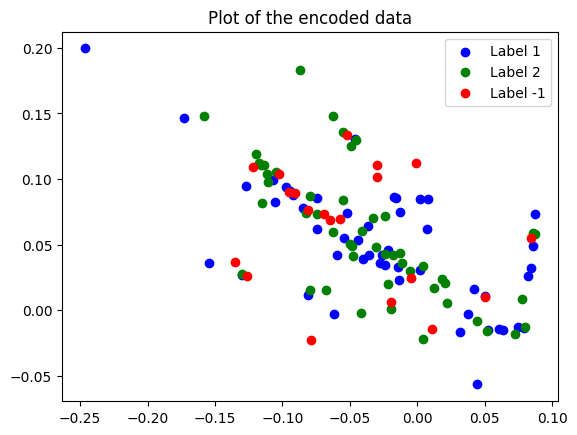

In [89]:
def get_encoded_data(x, autoenc, labels):
    with torch.no_grad():
        encoded = autoenc.encoder(x)
        decoded = autoenc.decoder(encoded)
        mse = loss(decoded, x).item()
        enc = encoded.cpu().detach().numpy()
        dec = decoded.cpu().detach().numpy()
    
    color_map = {1: 'blue', 2: 'green', -1: 'red'}
    

    for label_val in set(labels):
        label_indices = [i for i, label in enumerate(labels) if label == label_val]
        plt.scatter(enc[label_indices, 0], enc[label_indices, 1], 
                    c=color_map[label_val], label=f'Label {int(label_val)}')
    
    plt.title('Plot of the encoded data')
    plt.legend()
    plt.show()

labels = dataset[:, -1]
full_dset = torch.cat((train_data, test_data), dim=0)
get_encoded_data(full_dset, autoenc, labels)